## Importing modules

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import ConcatDataset
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
project_name = 'cifar10-resnet'

# The Dataset

In [3]:
# # Downloading the dataset
# dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
# download_url(dataset_url,'.')

# # Extract from archive
# with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
#     tar.extractall(path='./data')
    
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print("Classes are:\n", classes)

['test', 'train']
Classes are:
 ['truck', 'deer', 'cat', 'horse', 'dog', 'frog', 'bird', 'automobile', 'ship', 'airplane']


#### We can create training and validation datasets using the ImageFolder class from torchvision. There are a few important changes we'll make while creating PyTorch datasets for training and validation: 

#### 1. Use test set for validation: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.

#### 2. Channel-wise data normalization: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.


<img src = 'https://i.imgur.com/LYxXBVg.png'>

#### 3. Randomized data augmentations: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

In [4]:
# Data transformations (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding = 4, padding_mode = 'reflect'),
                        tt.RandomHorizontalFlip(),
#                         tt.RandomRotation(360),
#                         tt.RandomResizedCrop(256, scale = (0.5,0.9), ratio = (1,1)),
#                         tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#                         tt.RandomAdjustSharpness(0.4, p=0.2),
                        tt.ToTensor(),
                        tt.Normalize(*stats, inplace = True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [5]:
# Augmentation only tranforms the original dataset hence size remains same.
# To have both original and augmented images, we use ConcatDatset

# train_ds_aug = ImageFolder(data_dir+'/train', train_tfms)
# train_ds_org = ImageFolder(data_dir+'/train', transform = ToTensor())
# train_ds = ConcatDataset([train_ds_aug, train_ds_org])
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [6]:
batch_size = 128

# Pytorch data loaders. We only shuffle training images.
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True) 
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

#### To display some sample images, we'll need to denormalize the pixels values to bring them back to the range (0,1).

In [7]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)   #(batch,channels,row,column)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (12,12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow =8).permute(1,2,0).clamp(0,1))
        break

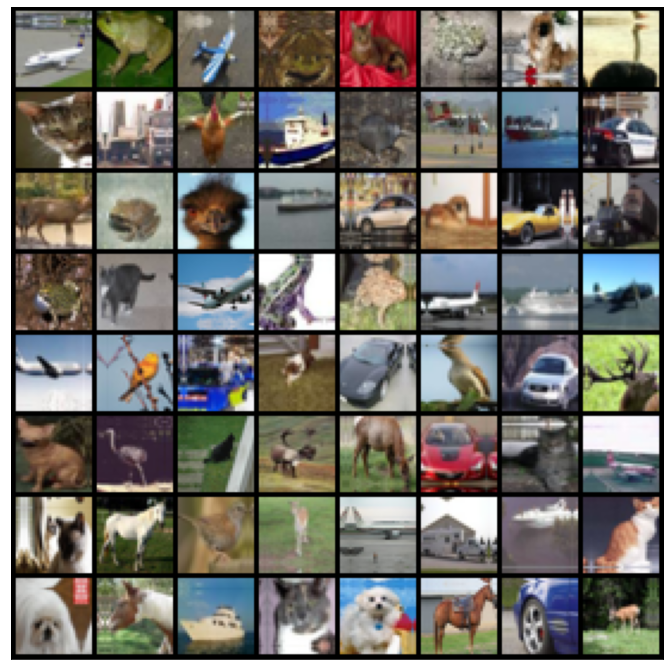

In [8]:
show_batch(train_dl)

#### In case batch consists of both original and augmented pictures, display will depict accordingly

In [9]:
# Using GPU if available in the system.

def get_dafault_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (tuple, list)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking= True)

class DeviceDataLoader():
    # Wrapping a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self. device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [10]:
device = get_dafault_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

### Creating model with Residual Blocks and Batch Normalization

<img src = 'https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png'>

In [12]:
# An example of a Residual network
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x    ## ReLU can be applied before or after adding the input

In [13]:
# Loading the model into GPU
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)                #(batch_size, no_of_channels,img_resolution)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([128, 3, 32, 32])


#### After each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous layer.

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim =1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print('Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(epoch,
        result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))


In [15]:
def  conv_block(in_channels, out_channels, pool = False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding = 1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

# Creating the ResNet class for our classification purpose.
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool = True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128,128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool = True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Dropout(0.2),
                                       nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out)+ out
        out = self.classifier(out)
        return out

In [16]:
# Loading our model to GPU
ResNetmodel = to_device(ResNet9(3, 10), device)
ResNetmodel

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

# Training

### Learning rate scheduling: 

#### Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the "One Cycle Learning Rate Policy", which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. 

### Weight decay:

####  We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.

### Gradient clipping:

#### Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping.

### Defining a fit_one_cycle function to incorporate these changes and recording the learning rate used:

In [17]:
@torch.no_grad()

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                 weight_decay=0, grad_clip=None, opt_func = torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # One-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch = len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            
            # Record and update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
            
        # Vaidation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [18]:
# Evaluating our untrained model with initial weights
history = [evaluate(ResNetmodel, valid_dl)]
history

[{'val_loss': 2.3008060455322266, 'val_acc': 0.09873046725988388}]

In [19]:
# Training our model for 25 epochs with the following hyper-parameters on GTX 1650 GPU with 8GB memory.
epochs = 25
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [20]:
%%time
history += fit_one_cycle(epochs, max_lr, ResNetmodel, train_dl, valid_dl, grad_clip=grad_clip,
                         weight_decay = weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00081, train_loss: 1.3708, val_loss: 0.8940, val_acc: 0.6888
Epoch [1], last_lr: 0.00199, train_loss: 0.9187, val_loss: 0.8212, val_acc: 0.7158
Epoch [2], last_lr: 0.00371, train_loss: 0.8213, val_loss: 0.8711, val_acc: 0.7074
Epoch [3], last_lr: 0.00570, train_loss: 0.7535, val_loss: 0.7141, val_acc: 0.7577
Epoch [4], last_lr: 0.00760, train_loss: 0.6684, val_loss: 0.7918, val_acc: 0.7385
Epoch [5], last_lr: 0.00908, train_loss: 0.6259, val_loss: 0.7421, val_acc: 0.7558
Epoch [6], last_lr: 0.00990, train_loss: 0.6098, val_loss: 1.2324, val_acc: 0.6542
Epoch [7], last_lr: 0.00998, train_loss: 0.6098, val_loss: 0.7063, val_acc: 0.7667
Epoch [8], last_lr: 0.00982, train_loss: 0.6102, val_loss: 1.0662, val_acc: 0.6953
Epoch [9], last_lr: 0.00950, train_loss: 0.6112, val_loss: 0.7408, val_acc: 0.7561
Epoch [10], last_lr: 0.00905, train_loss: 0.5996, val_loss: 0.6010, val_acc: 0.7971
Epoch [11], last_lr: 0.00846, train_loss: 0.5912, val_loss: 0.8060, val_acc: 0.7408
Ep

In [21]:
# Plotting accuracy through the training process
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs No. of epochs')

In [22]:
# Plotting losses through the training process
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

In [23]:
# Plotting the learning rate through the training process
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

# Testing with individual images

In [24]:
# Function to load, process and predict label for image
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return valid_ds.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: airplane , Predicted: airplane


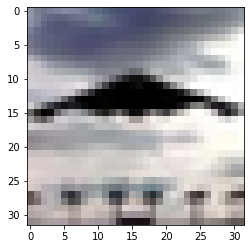

In [25]:
image, label = valid_ds[10]
img = denormalize(image, *stats)
tmp = img
plt.imshow(np.transpose(tmp[0].numpy(), (1, 2, 0)))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(image, ResNetmodel))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: automobile , Predicted: automobile


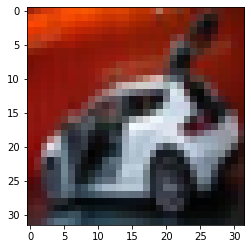

In [34]:
image, label = valid_ds[1000]
img = denormalize(image, *stats)
tmp = img
plt.imshow(np.transpose(tmp[0].numpy(), (1, 2, 0)))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(image, ResNetmodel))


Label: truck , Predicted: truck


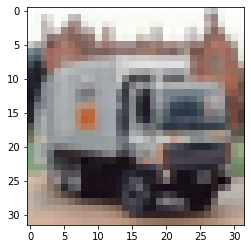

In [38]:
image, label = valid_ds[9000]
img = denormalize(image, *stats)
tmp = img
plt.imshow(np.transpose(tmp[0].numpy(), (1, 2, 0)))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(image, ResNetmodel))

# Saving the model 

In [26]:
# Saving the weights of the trained model
torch.save(ResNetmodel.state_dict(), 'cifar10ResNet.pth')

# Loading the model

In [27]:
# Initializing model using ResNet class
test_model = to_device(ResNet9(3, 10), device)

In [28]:
# Loading our saved weights to the initialised model
test_model.load_state_dict(torch.load('cifar10ResNet.pth'))

<All keys matched successfully>

In [30]:
# Evaluating our model to check if its the same
evaluate(test_model, valid_dl)

{'val_loss': 0.25980961322784424, 'val_acc': 0.9140625}

Label: airplane , Predicted: airplane


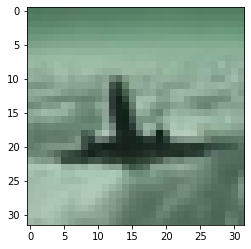

In [31]:
image, label = valid_ds[51]
img = denormalize(image, *stats)
tmp = img
plt.imshow(np.transpose(tmp[0].numpy(), (1, 2, 0)))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(image, test_model))


Label: dog , Predicted: dog


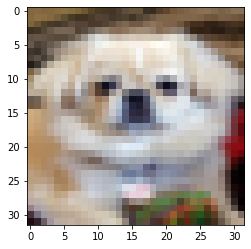

In [33]:
image, label = valid_ds[5100]
img = denormalize(image, *stats)
tmp = img
plt.imshow(np.transpose(tmp[0].numpy(), (1, 2, 0)))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(image, test_model))
